### Node for skullstrip

In [14]:
from nipype.interfaces.fsl import BET

from nipype.interfaces import fsl
from os.path import abspath
from nilearn.plotting import plot_anat
from os.path import join as opj
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode




In [2]:
bet=Node(BET(frac=0.5),name="BET_NODE")
#inputs and output
bet.inputs.in_file = '/data/ds000114/sub-03/ses-test/anat/sub-03_ses-test_T1w.nii.gz'
bet.outputs.out_file = '/output/node_Tw1_bet.nii.gz'

In [3]:
result = bet.run()

180227-19:45:53,982 workflow INFO:
	 Executing node BET_NODE in dir: /tmp/tmphp1ijrsh/BET_NODE
180227-19:45:53,995 workflow INFO:
	 Running node "BET_NODE" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /data/ds000114/sub-03/ses-test/anat/sub-03_ses-test_T1w.nii.gz /tmp/tmphp1ijrsh/BET_NODE/sub-03_ses-test_T1w_brain.nii.gz -f 0.50.


Populating the interactive namespace from numpy and matplotlib


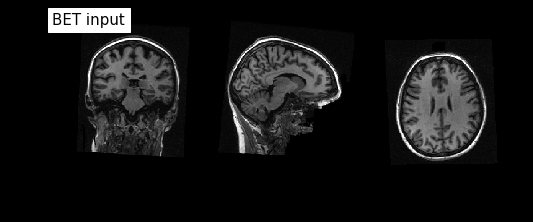

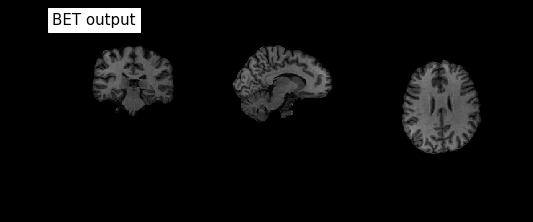

In [4]:
#plotting resuts


%pylab inline

plot_anat(bet.inputs.in_file, title='BET input', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_anat(result.outputs.out_file, title='BET output', cut_coords=(10,10,10),
          display_mode='ortho',draw_cross=False, annotate=False)



In [6]:


smooth_node = Node(fsl.IsotropicSmooth(), name="smoothing")
smooth_node.inputs.in_file = '/data/ds000114/sub-04/ses-test/anat/sub-04_ses-test_T1w.nii.gz'
smooth_node.inputs.fwhm = 4
smooth_node.inputs.out_file = '/output/node_T1w_smooth.nii.gz'
smooth_res = smooth_node.run()


180227-19:46:36,549 workflow INFO:
	 Executing node smoothing in dir: /tmp/tmp_dtjksnu/smoothing
180227-19:46:36,562 workflow INFO:
	 Running node "smoothing" ("nipype.interfaces.fsl.maths.IsotropicSmooth"), a CommandLine Interface with command:
fslmaths /data/ds000114/sub-04/ses-test/anat/sub-04_ses-test_T1w.nii.gz -s 1.69864 /output/node_T1w_smooth.nii.gz.


Populating the interactive namespace from numpy and matplotlib


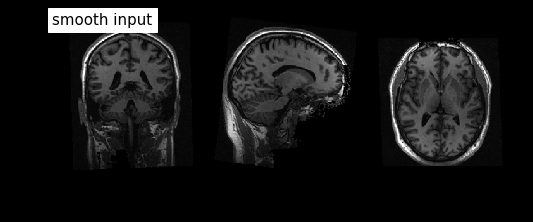

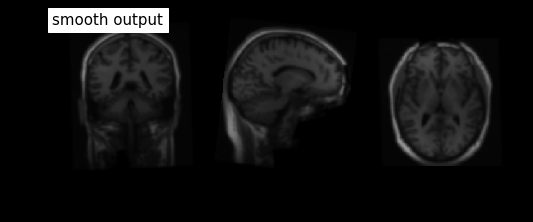

In [7]:


%pylab inline

plot_anat(smooth_node.inputs.in_file, title='smooth input', cut_coords=(10,10,10),
          display_mode='ortho', dim=-1, draw_cross=False, annotate=False)
plot_anat(smooth_res.outputs.out_file, title='smooth output', cut_coords=(10,10,10),
          display_mode='ortho',draw_cross=False, annotate=False)



## Workflow


In [8]:

in_file = abspath("/data/ds000114/sub-02/ses-test/anat/sub-02_ses-test_T1w.nii.gz")


skullstrip = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")

smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")


mask = Node(fsl.ApplyMask(), name="mask")



In [9]:

wf_1 = Workflow(name="smoothflow", base_dir="/output/working_dir")

wf_1.connect([(smooth, mask, [("out_file", "in_file")])])


In [10]:

wf_1.base_dir = "/output/working_dir"


wf_1.run()



180227-19:48:02,420 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
180227-19:48:02,428 workflow INFO:
	 Running serially.
180227-19:48:02,432 workflow INFO:
	 Executing node smoothflow.smooth in dir: /output/working_dir/smoothflow/smooth
180227-19:48:02,436 workflow INFO:
180227-19:48:02,442 workflow INFO:
	 Executing node smoothflow.mask in dir: /output/working_dir/smoothflow/mask
180227-19:48:02,456 workflow ERROR:
	 Node mask failed to run on host 61c607819510.
180227-19:48:02,463 workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/notebooks/crash-20180227-194802-neuro-mask-e42c1071-8c56-4b17-9160-2bdd76cdba9e.pklz
Traceback (most recent call last):
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 43, in run
    node.run(updatehash=updatehash)
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 407, in run
    self._run_interface()
  File "/

RuntimeError: Workflow did not execute cleanly. Check log for details

### Normalization using ANTS 

In [11]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

subject_list = ['sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-07', 'sub-08', 'sub-09']

task_name = "fingerfootlips"

fwhm = [4, 8]

template = '/data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

In [12]:
norm = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

In [15]:
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

templates = {'con': opj(output_dir, '1stLevel',
                        '{subject_id}/fwhm-{fwhm_id}', '???_00??.nii'),
             'transform': opj('/data/ds000114/derivatives/fmriprep/', '{subject_id}', 'anat',
                              '{subject_id}_t1w_space-mni152nlin2009casym_warp.h5')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")


datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")


substitutions = [('_subject_id_', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
subjFolders += [('_apply2con%s/' % (i), '') for i in range(9)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions



In [16]:

antsflow = Workflow(name='antsflow')
antsflow.base_dir = opj(experiment_dir, working_dir)

antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                             ('fwhm_id', 'fwhm_id')]),
                  (selectfiles, norm, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (norm, datasink, [('output_image', 'norm_ants.@con')]),
                  ])


In [17]:


antsflow.run('MultiProc', plugin_args={'n_procs': 4})



180227-19:49:38,717 workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging']
180227-19:49:38,855 workflow INFO:
	 Running in parallel.
180227-19:49:38,862 workflow INFO:
	 Currently running 0 tasks, and 14 jobs ready. Free memory (GB): 3.38/3.38, Free processors: 4/4
180227-19:49:38,870 workflow INFO:
	 Executing node antsflow.selectfiles in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-09/selectfiles180227-19:49:38,878 workflow INFO:
	 Executing node antsflow.selectfiles in dir: /output/workingdir/antsflow/_fwhm_id_8_subject_id_sub-08/selectfiles

180227-19:49:38,885 workflow INFO:
	 Executing node antsflow.selectfiles in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-08/selectfiles180227-19:49:38,877 workflow INFO:
	 Executing node antsflow.selectfiles in dir: /output/workingdir/antsflow/_fwhm_id_4_subject_id_sub-09/selectfiles180227-19:49:38,916 workflow INFO:
	 Running node "selectfiles" ("nipype.interfaces.io.SelectFiles").
180227-19:

180227-19:49:45,76 workflow ERROR:
	 Node selectfiles.a04 failed to run on host 61c607819510.
180227-19:49:45,84 workflow ERROR:
	 Saving crash info to /home/neuro/nipype_tutorial/notebooks/crash-20180227-194945-neuro-selectfiles.a04-2895cc96-108c-419d-ac2e-d7847df8726a.pklz
Traceback (most recent call last):
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 51, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 407, in run
    self._run_interface()
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 517, in _run_interface
    self._result = self._run_command(execute)
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 650, in _run_command
    result = self._interface.run()
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipy

180227-19:49:49,173 workflow INFO:
	 ***********************************
180227-19:49:49,175 workflow ERROR:
	 could not run node: antsflow.selectfiles.a13
180227-19:49:49,177 workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/notebooks/crash-20180227-194940-neuro-selectfiles.a13-f99cdca0-c75d-4511-8c63-5a117e7acb9a.pklz
180227-19:49:49,182 workflow ERROR:
	 could not run node: antsflow.selectfiles.a12
180227-19:49:49,185 workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/notebooks/crash-20180227-194940-neuro-selectfiles.a12-c40d12e7-a10a-412e-88da-335b59c20227.pklz
180227-19:49:49,187 workflow ERROR:
	 could not run node: antsflow.selectfiles.a11
180227-19:49:49,190 workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/notebooks/crash-20180227-194940-neuro-selectfiles.a11-97238ada-41ca-41d4-87ca-414a2922b355.pklz
180227-19:49:49,197 workflow ERROR:
	 could not run node: antsflow.selectfiles.a10
180227-19:49:49,200 workflow INFO:
	 crashfile: /home/neuro/nipype_tutorial/not

RuntimeError: Workflow did not execute cleanly. Check log for details